### Imported Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import lightgbm as lgbm
import matplotlib
import multiprocessing
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

### Feature Extraction Functions

In [2]:
DENORM = pd.read_csv("denormalize_multipliers.csv")

def mad(data):
    return np.mean(np.absolute(data - np.mean(data)))

def import_beta(df):
    df = df.merge(pd.read_csv("all_times.csv"), how='left').fillna(1)
    return df.drop(['spread'], axis=1).drop(['dom'], axis=1)
    
def compute_wap(df):
    return (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) \
          /(df['bid_size1'] + df['ask_size1'])

def compute_wap2(df):
    return (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) \
           /(df['bid_size2'] + df['ask_size2'])

def compute_dom(df):
    dom = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            + (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])
    return dom

def compute_dom_diff(df):
    dom_diff = abs((df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            - (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2']))
    return dom_diff

def fill_seconds(df):
    df = df.reset_index(drop=True)
    index_range = pd.Index(range(600), name='seconds_in_bucket')
    df = df.set_index('seconds_in_bucket').reindex(index_range)
    
    # Forward fill & back fill seconds
    df = df.ffill().reset_index()
    return df.bfill().iloc[:600]

def target_encoding(df):
    enc = np.repeat(np.nan, df.shape[0])
    kf = KFold(n_splits = 10, shuffle=True,random_state = 0)
    for idx_1, idx_2 in kf.split(df):
        tmean = df.iloc[idx_1].groupby('stock_id')['target_realized_volatility'].mean()
        enc[idx_2] = df['stock_id'].iloc[idx_2].map(tmean)
    df['target_mean_enc'] = enc
    return df

def generate_feature_seconds(features, df, feats, seconds=[300], overlap=1):
    if overlap:
        for second in seconds:
            res = pd.DataFrame(
                df.query(f'{seconds[0]-second} <= seconds_in_bucket < {seconds[0]}')
                .groupby(['time_id']).agg(feats)
            ).reset_index()
            res.columns = ['_'.join(feat).rstrip('_') for feat in res.columns]
            res = res.add_suffix('_' + str(second))
            features = pd.merge(
                features, res, 
                how='left', 
                left_on='time_id', 
                right_on=f'time_id_{second}'
            )
            features = features.drop([f'time_id_{second}'], axis=1)  
    else:
        if len(seconds) > 1:
            gap = seconds[1]-seconds[2]
        else:
            gap = 0
        for i, second in enumerate(seconds):
            last_second = 0 if not i else seconds[i-1]
            res = pd.DataFrame(
                df.query(f'{last_second} <= seconds_in_bucket < {second}')
                .groupby(['time_id']).agg(feats)
            ).reset_index()
            res.columns = ['_'.join(feat).rstrip('_') for feat in res.columns]
            res = res.add_suffix('_' + str(second))
            features = pd.merge(
                features, res, 
                how='left', 
                left_on='time_id', 
                right_on=f'time_id_{second}'
            )
            features = features.drop([f'time_id_{second}'], axis=1)
    return features

def generate_target(df, target, second=300):
    features = pd.DataFrame(
        df.query(f'seconds_in_bucket >= {second}')
        .groupby(['time_id']).agg(target)
    ).reset_index()
    features.columns = ['_'.join(feat).rstrip('_') for feat in features.columns]
    return features

def calc_slope(df):
    v0 = (df['bid_size1']+df['ask_size1'])/2
    p0 = (df['bid_price1']+df['ask_price1'])/2
    slope_bid = ((df['bid_size1']/v0)-1)/abs((df['bid_price1']/p0)-1)+(
                (df['bid_size2']/df['bid_size1'])-1)/abs((df['bid_price2']/df['bid_price1'])-1)
    slope_ask = ((df['ask_size1']/v0)-1)/abs((df['ask_price1']/p0)-1)+(
                (df['ask_size2']/df['ask_size1'])-1)/abs((df['ask_price2']/df['ask_price1'])-1)
    return (slope_bid+slope_ask)/2, abs(slope_bid-slope_ask)


def calc_dispersion(df):
    bspread = df['bid_diff']
    aspread = df['ask_diff']
    bmid = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price1']
    bmid2 = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price2']
    amid = df['ask_price1'] - (df['bid_price1'] + df['ask_price1'])/2
    amid2 = df['ask_price2'] - (df['bid_price1'] + df['ask_price1'])/2
    bdisp = (df['bid_size1']*bmid + df['bid_size2']*bspread)/(df['bid_size1']+df['bid_size2'])
    bdisp2 = (df['bid_size1']*bmid + df['bid_size2']*bmid2)/(df['bid_size1']+df['bid_size2'])
    adisp = (df['ask_size1']*amid + df['ask_size2']*aspread)/(df['ask_size1']+df['ask_size2'])      
    adisp2 = (df['ask_size1']*amid + df['ask_size2']*amid2)/(df['ask_size1']+df['ask_size2'])
    return (bdisp + adisp)/2, (bdisp2 + adisp2)/2

def calc_price_impact(df):
    ask = (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])/(df['ask_size1']+df['ask_size2'])
    bid = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2'])/(df['bid_size1']+df['bid_size2'])
    return (df['ask_price1'] - ask)/df['ask_price1'], (df['bid_price1'] - bid)/df['bid_price1']


def calc_ofi(df):
    a = df['bid_size1']*np.where(df['bid_price1'].diff()>=0,1,0)
    b = df['bid_size1'].shift()*np.where(df['bid_price1'].diff()<=0,1,0)
    c = df['ask_size1']*np.where(df['ask_price1'].diff()<=0,1,0)
    d = df['ask_size1'].shift()*np.where(df['ask_price1'].diff()>=0,1,0)
    return a - b - c + d


def calc_tt1(df):
    p1 = df['ask_price1'] * df['ask_size1'] + df['bid_price1'] * df['bid_size1']
    p2 = df['ask_price2'] * df['ask_size2'] + df['bid_price2'] * df['bid_size2']      
    return p2 - p1 

def log_returns(waps):
    return np.log(waps).diff() 

def realized_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2))

def weighted_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2)/log_returns.count())

def quarticity(s):
    return (s.count()/3) * np.sum(s**4)

def denorm(df):
    global DENORM
    df = df.merge(DENORM, how="left")
    df['ask_price1'] *= df['multiplier']
    df['ask_price2'] *= df['multiplier']
    df['bid_price1'] *= df['multiplier']
    df['bid_price2'] *= df['multiplier']
    return df.drop(['multiplier'], axis=1)

### Generate Features for First 5 Minutes of Each Stock 

In [3]:
def concat_features(stock_id, df):
    file = f"individual_book_train/stock_{stock_id}.csv"        
    return pd.concat([df, generate_features(file)])

def process_stocks(stock_ids):
    df = pd.DataFrame()
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(concat_features)(stock_id, df) for stock_id in stock_ids
    )
    # lastly import pre-computed beta coefficients for all stock_ids
    return import_beta(target_encoding(pd.concat(df, ignore_index = True)))

def generate_features(file_path):
    df = pd.read_csv(file_path)
    
    # denormalize prices
    #df = denorm(df)
    
    # fill seconds
    df = df.groupby('time_id').apply(fill_seconds).reset_index(drop=True)
    
    # compute waps for first and second ask/bids 
    df['wap'] = compute_wap(df)
    df['wap2'] = compute_wap2(df)
    
    # compute log returns for realized volatility
    df['log_returns'] = df.groupby('time_id')['wap'].apply(log_returns)
    df['log_returns2'] = df.groupby('time_id')['wap2'].apply(log_returns)
    
    # compute difference in waps and price as feature
    df['wap_diff'] = abs(df['wap'] - df['wap2'])
    
    # price difference regularized
    df['price_diff'] = (df['ask_price1'] - df['bid_price1']) \
                        / ((df['ask_price1'] + df['bid_price1'])/2)
    df['price_diff2'] = (df['ask_price2'] - df['bid_price2']) \
                        / ((df['ask_price2'] + df['bid_price2'])/2)
    
    # difference between first and second bid/ask price
    df['bid_diff'] = df['bid_price1'] - df['bid_price2']
    df['ask_diff'] = df['ask_price1'] - df['ask_price2']
    
    # sum of first and second ask sizes and bid sizes
    df['bid_ask_volume'] = (df['ask_size1'] + df['ask_size2']) \
                        + (df['bid_size1'] + df['bid_size2'])
    
    # diff between ask sizes and bid sizes 
    df['bid_ask_volume_diff'] = abs((df['ask_size1'] + df['ask_size2']) \
                                - (df['bid_size1'] + df['bid_size2']))

    # depth of market and difference
    df['dom'] = compute_dom(df)
    df['dom_diff'] = compute_dom_diff(df)
    df['dom_imbalance'] = abs(df['dom'] - df['dom_diff'])
    
    # bid ask spread from lecture/lab
    df["bid_ask_spread1"] = df['ask_price1'] / df['bid_price1'] - 1
    df["bid_ask_spread2"] = df['ask_price2'] / df['bid_price2'] - 1
    df['bid_ask_spread3'] = abs(df['bid_diff'] - df['ask_diff'])
    
    df["slope"], _ = calc_slope(df)
    df["dispersion"], _ = calc_dispersion(df)
    df["price_impact"], _ = calc_price_impact(df)
    df["ofi"] = calc_ofi(df)
    df["turn_over"] = calc_tt1(df)
    
    
    df['target'] =  df.groupby('time_id')['wap'].apply(log_returns)
    
    target_dict = {'target':[realized_volatility]}
    feature_dict = {
        'wap':[np.mean, np.std],#, mad, np.max, np.sum],
        'wap2':[np.mean, np.std],#, mad, np.max, np.sum],
        'log_returns':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean, np.std],
        'log_returns2':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean, np.std],
        'wap_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'price_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'price_diff2':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'ask_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_volume':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_volume_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'dom':[np.mean, np.std],#, mad, np.max, np.sum],
        'dom_diff':[np.mean, np.std],#, mad, np.max, np.sum],
        'dom_imbalance':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread1':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread2':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread3':[np.mean, np.std],#, mad, np.max, np.sum],
        #'slope':[np.mean, np.std],#, mad, np.max, np.sum],
        #'dispersion':[np.mean, np.std],#, mad, np.max, np.sum],
        #'price_impact':[np.mean, np.std],#, mad, np.max, np.sum],
        'ofi':[np.mean, np.std],#, mad, np.max, np.sum],
        #'turn_over':[np.mean, np.std]#, mad, np.max, np.sum],
    }
    
    # target realized volatility for next 300 second (5 min window in time_id)
    feature = generate_target(
        df, target=target_dict, 
        second=300  # target volatility is for next 300 second (no overlap)
    )
    
    # obtain features over entire 5 mins or last 2.5 mins..
    feature = generate_feature_seconds(
        feature, df, 
        feats=feature_dict, 
        seconds=[300, 150],  # features generated for each second interval (different widths)
        overlap=1,
    )

    #create stock_id
    feature['stock_id'] = int(file_path.split('/')[1].split('_')[1].split('.')[0])
    feature['time_id'] = feature['time_id'].apply(int)
    
    return feature

## Process Features for All Stocks

In [4]:
all_stocks = process_stocks(pd.read_csv("all_times.csv").stock_id.unique())
all_stocks

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  5.3min finished


,time_id,target_realized_volatility,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,...,bid_ask_spread1_std_150,bid_ask_spread2_mean_150,bid_ask_spread2_std_150,bid_ask_spread3_mean_150,bid_ask_spread3_std_150,ofi_mean_150,ofi_std_150,stock_id,target_mean_enc,beta
0,5,0.002954,1.003597,0.000851,1.003512,0.001014,0.003394,0.000196,4.521321e-10,7.138250e-06,...,0.000178,0.001210,0.000205,0.000287,0.000164,12.646667,79.839784,0,0.002943,1.208072
1,11,0.000981,0.999987,0.000156,0.999983,0.000182,0.000699,0.000040,2.123766e-12,8.823633e-07,...,0.000090,0.000577,0.000130,0.000228,0.000090,0.680000,14.913766,0,0.002974,1.719756
2,16,0.001295,0.999960,0.000444,1.000110,0.000470,0.001983,0.000115,1.070617e-10,1.729093e-06,...,0.000147,0.001063,0.000226,0.000414,0.000187,-3.873333,73.061461,0,0.002985,7.164047
3,31,0.001776,0.999219,0.000846,0.998835,0.000762,0.001863,0.000108,1.551546e-10,-5.516464e-06,...,0.000204,0.001365,0.000316,0.000260,0.000190,-4.780000,47.926520,0,0.002974,6.559597
4,62,0.001520,0.999769,0.000238,0.999684,0.000335,0.001131,0.000065,3.550845e-11,-2.164288e-06,...,0.000115,0.000579,0.000215,0.000253,0.000161,1.920000,54.132019,0,0.002974,0.680616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,32751,0.002899,0.999751,0.000534,0.999942,0.000673,0.002284,0.000132,2.117007e-10,-2.858852e-06,...,0.000223,0.001238,0.000213,0.000354,0.000208,3.166667,98.108105,126,0.003887,0.895436
428928,32753,0.003454,1.001470,0.000507,1.001513,0.000567,0.002217,0.000128,9.484441e-11,3.674218e-06,...,0.000189,0.000922,0.000149,0.000187,0.000134,4.560000,39.112723,126,0.003887,-1.346971
428929,32758,0.002792,1.000656,0.000319,1.000586,0.000396,0.001386,0.000080,3.031629e-11,-2.437732e-06,...,0.000193,0.001094,0.000198,0.000250,0.000086,2.626667,51.226900,126,0.003904,0.904714
428930,32763,0.002379,1.001787,0.000449,1.001794,0.000494,0.002783,0.000161,1.960849e-10,6.737309e-06,...,0.000127,0.000847,0.000172,0.000301,0.000132,-14.680000,120.096456,126,0.003904,-0.099107


### Feature Cluster Labels

In [76]:
labels = pd.read_csv("pca10_clusts.csv").iloc[:,1:]
labels

,kmeans5,agg_ward10,dbscan61,gmm12,stock_id
0,0,1,0,5,0
1,4,3,1,0,1
2,1,7,1,3,2
3,4,4,2,5,3
4,4,3,3,0,4
...,...,...,...,...,...
107,4,7,1,3,122
108,1,7,9,10,123
109,2,6,59,6,124
110,1,9,60,4,125


In [119]:
feats2clust = pd.read_csv("feats_to_cluster.csv").iloc[:,1:]
feats2clust

,stock_id,mean_beta,mad_beta,mean_dom,mad_dom,mean_spread,mad_spread,mean_ldom,mad_ldom
0,0,0.906933,1.289825,391.190041,77.853000,0.001025,0.000565,5.969193,4.354822
1,1,1.495206,1.658282,544.613121,126.319791,0.000709,0.000334,6.300076,4.838817
2,2,0.385722,1.098470,834.443954,230.700291,0.000260,0.000157,6.726766,5.441119
3,3,1.816914,2.728843,519.413360,134.556146,0.001074,0.000445,6.252700,4.901982
4,4,0.723135,1.431139,357.310446,71.485457,0.000910,0.000459,5.878605,4.269494
...,...,...,...,...,...,...,...,...,...
107,122,1.320618,1.360773,597.760696,104.266435,0.000627,0.000341,6.393191,4.646950
108,123,0.835223,1.214954,1625.191286,624.340179,0.000230,0.000098,7.393381,6.436695
109,124,1.644451,2.055664,3982.139497,2052.221583,0.000205,0.000037,8.289575,7.626678
110,125,0.494871,1.124019,3141.556105,1208.901021,0.000229,0.000064,8.052474,7.097467


In [131]:
labels2 = pd.read_csv("cluster_labels.csv").iloc[:,1:]
labels2

,bds_kmeans4,bds_agg_ward4,bds_dbscan_ward5,bds_gmm6,stock_id
0,1,4,0,0,0
1,2,1,3,2,1
2,3,4,1,5,2
3,1,2,-1,2,3
4,3,4,0,0,4
...,...,...,...,...,...
107,2,1,3,2,122
108,0,3,-1,1,123
109,2,1,-1,1,124
110,0,3,2,5,125


In [134]:
all_stocks = all_stocks.merge(labels, how="left")
all_stocks = all_stocks.merge(feats2clust, how="left")
all_stocks = all_stocks.merge(labels2, how="left")

all_stocks

,time_id,target_realized_volatility,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,...,mean_dom,mad_dom,mean_spread,mad_spread,mean_ldom,mad_ldom,bds_kmeans4,bds_agg_ward4,bds_dbscan_ward5,bds_gmm6
0,5,0.002954,1.003597,0.000851,1.003512,0.001014,0.003394,0.000196,4.521321e-10,7.138250e-06,...,391.190041,77.853000,0.001025,0.000565,5.969193,4.354822,1,4,0,0
1,11,0.000981,0.999987,0.000156,0.999983,0.000182,0.000699,0.000040,2.123766e-12,8.823633e-07,...,391.190041,77.853000,0.001025,0.000565,5.969193,4.354822,1,4,0,0
2,16,0.001295,0.999960,0.000444,1.000110,0.000470,0.001983,0.000115,1.070617e-10,1.729093e-06,...,391.190041,77.853000,0.001025,0.000565,5.969193,4.354822,1,4,0,0
3,31,0.001776,0.999219,0.000846,0.998835,0.000762,0.001863,0.000108,1.551546e-10,-5.516464e-06,...,391.190041,77.853000,0.001025,0.000565,5.969193,4.354822,1,4,0,0
4,62,0.001520,0.999769,0.000238,0.999684,0.000335,0.001131,0.000065,3.550845e-11,-2.164288e-06,...,391.190041,77.853000,0.001025,0.000565,5.969193,4.354822,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,32751,0.002899,0.999751,0.000534,0.999942,0.000673,0.002284,0.000132,2.117007e-10,-2.858852e-06,...,382.733699,72.076705,0.001107,0.000522,5.947339,4.277731,1,2,-1,2
428928,32753,0.003454,1.001470,0.000507,1.001513,0.000567,0.002217,0.000128,9.484441e-11,3.674218e-06,...,382.733699,72.076705,0.001107,0.000522,5.947339,4.277731,1,2,-1,2
428929,32758,0.002792,1.000656,0.000319,1.000586,0.000396,0.001386,0.000080,3.031629e-11,-2.437732e-06,...,382.733699,72.076705,0.001107,0.000522,5.947339,4.277731,1,2,-1,2
428930,32763,0.002379,1.001787,0.000449,1.001794,0.000494,0.002783,0.000161,1.960849e-10,6.737309e-06,...,382.733699,72.076705,0.001107,0.000522,5.947339,4.277731,1,2,-1,2


In [135]:
len(all_stocks[all_stocks['target_realized_volatility']==0])

1

### Removing row with zero realized volatility
* Only one row where target_realized_vol = 0
* Corrupts RMSPE and MAPE metric scores
    * Denominator is y_true
    * Added small epsilon to prevent zerodivision
    * Results in very large error if y_true = 0

In [136]:
nozeros = all_stocks[all_stocks['target_realized_volatility'] != 0].reset_index(drop=True)
nozeros

,time_id,target_realized_volatility,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,...,mean_dom,mad_dom,mean_spread,mad_spread,mean_ldom,mad_ldom,bds_kmeans4,bds_agg_ward4,bds_dbscan_ward5,bds_gmm6
0,5,0.002954,1.003597,0.000851,1.003512,0.001014,0.003394,0.000196,4.521321e-10,7.138250e-06,...,391.190041,77.853000,0.001025,0.000565,5.969193,4.354822,1,4,0,0
1,11,0.000981,0.999987,0.000156,0.999983,0.000182,0.000699,0.000040,2.123766e-12,8.823633e-07,...,391.190041,77.853000,0.001025,0.000565,5.969193,4.354822,1,4,0,0
2,16,0.001295,0.999960,0.000444,1.000110,0.000470,0.001983,0.000115,1.070617e-10,1.729093e-06,...,391.190041,77.853000,0.001025,0.000565,5.969193,4.354822,1,4,0,0
3,31,0.001776,0.999219,0.000846,0.998835,0.000762,0.001863,0.000108,1.551546e-10,-5.516464e-06,...,391.190041,77.853000,0.001025,0.000565,5.969193,4.354822,1,4,0,0
4,62,0.001520,0.999769,0.000238,0.999684,0.000335,0.001131,0.000065,3.550845e-11,-2.164288e-06,...,391.190041,77.853000,0.001025,0.000565,5.969193,4.354822,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428926,32751,0.002899,0.999751,0.000534,0.999942,0.000673,0.002284,0.000132,2.117007e-10,-2.858852e-06,...,382.733699,72.076705,0.001107,0.000522,5.947339,4.277731,1,2,-1,2
428927,32753,0.003454,1.001470,0.000507,1.001513,0.000567,0.002217,0.000128,9.484441e-11,3.674218e-06,...,382.733699,72.076705,0.001107,0.000522,5.947339,4.277731,1,2,-1,2
428928,32758,0.002792,1.000656,0.000319,1.000586,0.000396,0.001386,0.000080,3.031629e-11,-2.437732e-06,...,382.733699,72.076705,0.001107,0.000522,5.947339,4.277731,1,2,-1,2
428929,32763,0.002379,1.001787,0.000449,1.001794,0.000494,0.002783,0.000161,1.960849e-10,6.737309e-06,...,382.733699,72.076705,0.001107,0.000522,5.947339,4.277731,1,2,-1,2


### Defining X for LightGBM

* should scale features if regularization?

In [137]:
all_stocks_X = nozeros.drop(['time_id','target_realized_volatility'], axis=1)  # leave stock id as feature 
#all_stocks_X[:] = (all_stocks_X).transform(all_stocks_X)
all_stocks_X

,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,log_returns_std_300,log_returns2_realized_volatility_300,...,mean_dom,mad_dom,mean_spread,mad_spread,mean_ldom,mad_ldom,bds_kmeans4,bds_agg_ward4,bds_dbscan_ward5,bds_gmm6
0,1.003597,0.000851,1.003512,0.001014,0.003394,0.000196,4.521321e-10,7.138250e-06,0.000196,0.005032,...,391.190041,77.853000,0.001025,0.000565,5.969193,4.354822,1,4,0,0
1,0.999987,0.000156,0.999983,0.000182,0.000699,0.000040,2.123766e-12,8.823633e-07,0.000040,0.001448,...,391.190041,77.853000,0.001025,0.000565,5.969193,4.354822,1,4,0,0
2,0.999960,0.000444,1.000110,0.000470,0.001983,0.000115,1.070617e-10,1.729093e-06,0.000115,0.003583,...,391.190041,77.853000,0.001025,0.000565,5.969193,4.354822,1,4,0,0
3,0.999219,0.000846,0.998835,0.000762,0.001863,0.000108,1.551546e-10,-5.516464e-06,0.000108,0.002422,...,391.190041,77.853000,0.001025,0.000565,5.969193,4.354822,1,4,0,0
4,0.999769,0.000238,0.999684,0.000335,0.001131,0.000065,3.550845e-11,-2.164288e-06,0.000065,0.002412,...,391.190041,77.853000,0.001025,0.000565,5.969193,4.354822,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428926,0.999751,0.000534,0.999942,0.000673,0.002284,0.000132,2.117007e-10,-2.858852e-06,0.000132,0.004503,...,382.733699,72.076705,0.001107,0.000522,5.947339,4.277731,1,2,-1,2
428927,1.001470,0.000507,1.001513,0.000567,0.002217,0.000128,9.484441e-11,3.674218e-06,0.000128,0.003652,...,382.733699,72.076705,0.001107,0.000522,5.947339,4.277731,1,2,-1,2
428928,1.000656,0.000319,1.000586,0.000396,0.001386,0.000080,3.031629e-11,-2.437732e-06,0.000080,0.002686,...,382.733699,72.076705,0.001107,0.000522,5.947339,4.277731,1,2,-1,2
428929,1.001787,0.000449,1.001794,0.000494,0.002783,0.000161,1.960849e-10,6.737309e-06,0.000161,0.004316,...,382.733699,72.076705,0.001107,0.000522,5.947339,4.277731,1,2,-1,2


### Defining y for LightGBM

In [138]:
all_stocks_y = nozeros[['target_realized_volatility', 'stock_id', 'time_id']]
len(all_stocks_y.time_id.unique())

3830

In [139]:
all_stocks_y

,target_realized_volatility,stock_id,time_id
0,0.002954,0,5
1,0.000981,0,11
2,0.001295,0,16
3,0.001776,0,31
4,0.001520,0,62
...,...,...,...
428926,0.002899,126,32751
428927,0.003454,126,32753
428928,0.002792,126,32758
428929,0.002379,126,32763


Note: Including stock_id and time_id for logging predictions for app (target_realized_volatility is only target)

## Training LightGBM

### Model Helper Functions

In [140]:
EPSILON = 0 #1e-10 set epsilon to zero as removed zero row for realized volatility

def compute_importance(model, features, typ='gain'):
    return pd.DataFrame(
        model.feature_importance(importance_type=typ),
        index=features,
        columns=['importance']
    ).sort_values('importance')
    
def rmspe(y_true, y_pred):
    return  np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + EPSILON))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds), 4), False

### Nested 5-Fold Cross-Validation

In [141]:
%%time
test = pd.DataFrame({'target_realized_volatility':[],'predicted_volatility': [],'time_id':[], 'stock_id':[]})
all_models = []
split_importance = []
gain_importance = []
train_scores = []
inner_k = 5
outer_k = 5

# some params taken from research paper (link @ bottom of notebook)
params = {
    "objective": "regression",
    "metric": "rmse", 
    "boosting_type": "gbdt",
    "feature_fraction": 0.8,  
    "bagging_fraction": 0.8,
    "learning_rate": 0.01,
    "n_jobs": -1,
    "lambda_l1": 1,
    "lambda_l2": 1,
    "force_col_wise": True,
  }


outer_kfold = KFold(n_splits=outer_k, random_state=0, shuffle=True)
for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_kfold.split(all_stocks_X, all_stocks_y)):
    print('*'*120)
    print("Outer Fold :", outer_fold + 1)
    print('*'*120)

    X_outer_train = all_stocks_X.iloc[outer_train_idx].reset_index(drop=True)
    y_outer_train = all_stocks_y.iloc[outer_train_idx].reset_index(drop=True)
    X_outer_test = all_stocks_X.iloc[outer_test_idx].reset_index(drop=True)
    y_outer_test = all_stocks_y.iloc[outer_test_idx].reset_index(drop=True)
    
    target = np.zeros(len(y_outer_test))
    inner_scores = 0.0
    models = []
    inner_kfold = KFold(n_splits= inner_k, random_state=0, shuffle=True)
    for inner_fold, (inner_train_idx, inner_valid_idx) in enumerate(inner_kfold.split(X_outer_train, y_outer_train)):
        print("\n\t"+"*"*20)
        print(f"\t*  Inner Fold : {inner_fold + 1}  *")
        print("\t"+"*"*20+"\n")
    
        # inner train data and valid data
        X_inner_train = X_outer_train.iloc[inner_train_idx].reset_index(drop=True)
        y_inner_train = y_outer_train.iloc[inner_train_idx].reset_index(drop=True)['target_realized_volatility']
        X_inner_valid = X_outer_train.iloc[inner_valid_idx].reset_index(drop=True)
        y_inner_valid = y_outer_train.iloc[inner_valid_idx].reset_index(drop=True)['target_realized_volatility']
    
        lgbm_train = lgbm.Dataset(
            X_inner_train, 
            y_inner_train, 
            weight = 1 / (np.square(y_inner_train.values)+EPSILON)         # weighting rmspe
        )
        lgbm_valid = lgbm.Dataset(
            X_inner_valid, 
            y_inner_valid, 
            reference = lgbm_train, 
            weight = 1 / (np.square(y_inner_valid.values)+EPSILON)        # weighting rmspe
        )
        # model training
        model = lgbm.train(
            params=params,
            train_set=lgbm_train,
            valid_sets=[lgbm_train, lgbm_valid],
            num_boost_round=5000,       
            feval=feval_RMSPE,
            callbacks=[lgbm.log_evaluation(period=100), lgbm.early_stopping(50)]
        )
        # validation 
        y_inner_pred = model.predict(X_inner_valid, num_iteration=model.best_iteration)
        RMSPE = rmspe(
            y_true=(y_inner_valid.values.flatten()), 
            y_pred=(y_inner_pred)
        )
        
        print("\t"+"*" * 100)
        print(f'\tInner Validation RMSPE: {RMSPE}')
        print("\t"+"*" * 100)

        # keep training validation score
        inner_scores += RMSPE / inner_k
        models.append(model)
        
        # record feature importances by gain and split
        features = list(X_inner_train.columns.values)
        gain_importance.append(compute_importance(model, features, typ='gain'))
        split_importance.append(compute_importance(model, features, typ='split'))
    
    # store all models for prediction in oof evaluation
    all_models.append(models)
    train_scores.append(inner_scores)
    
    # out of fold test set
    for model in all_models[outer_fold]:
        y_outer_pred = model.predict(X_outer_test, num_iteration=model.best_iteration)
        target += y_outer_pred / len(all_models[outer_fold])
        
    y_outer_test = y_outer_test.assign(predicted_volatility = target)
    test = pd.concat([test, y_outer_test]).reset_index(drop=True)

************************************************************************************************************************
Outer Fold : 1
************************************************************************************************************************

	********************
	*  Inner Fold : 1  *
	********************

[LightGBM] [Info] Total Bins 23054
[LightGBM] [Info] Number of data points in the train set: 274515, number of used features: 103
[LightGBM] [Info] Start training from score 0.001177
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.000474845	training's RMSPE: 0.3256	valid_1's rmse: 0.000477267	valid_1's RMSPE: 0.3264
[200]	training's rmse: 0.000384613	training's RMSPE: 0.2637	valid_1's rmse: 0.000390978	valid_1's RMSPE: 0.2674
[300]	training's rmse: 0.000364596	training's RMSPE: 0.25	valid_1's rmse: 0.000372627	valid_1's RMSPE: 0.2548
[400]	training's rmse: 0.000357552	training's RMSPE: 0.2452	valid_1's rmse: 0.000367198	valid_1's

[500]	training's rmse: 0.000355415	training's RMSPE: 0.2417	valid_1's rmse: 0.000393339	valid_1's RMSPE: 0.2776
[600]	training's rmse: 0.000352372	training's RMSPE: 0.2396	valid_1's rmse: 0.000390358	valid_1's RMSPE: 0.2755
Early stopping, best iteration is:
[614]	training's rmse: 0.000351984	training's RMSPE: 0.2394	valid_1's rmse: 0.000389963	valid_1's RMSPE: 0.2752
	****************************************************************************************************
	Inner Validation RMSPE: 0.2752353043135658
	****************************************************************************************************
************************************************************************************************************************
Outer Fold : 2
************************************************************************************************************************

	********************
	*  Inner Fold : 1  *
	********************

[LightGBM] [Info] Total Bins 23054
[LightGBM] [Info] Num

[200]	training's rmse: 0.000386447	training's RMSPE: 0.2626	valid_1's rmse: 0.000430456	valid_1's RMSPE: 0.3003
[300]	training's rmse: 0.000366633	training's RMSPE: 0.2492	valid_1's rmse: 0.00040732	valid_1's RMSPE: 0.2841
[400]	training's rmse: 0.000359522	training's RMSPE: 0.2443	valid_1's rmse: 0.000401111	valid_1's RMSPE: 0.2798
[500]	training's rmse: 0.000355336	training's RMSPE: 0.2415	valid_1's rmse: 0.000397756	valid_1's RMSPE: 0.2775
[600]	training's rmse: 0.000352129	training's RMSPE: 0.2393	valid_1's rmse: 0.000396501	valid_1's RMSPE: 0.2766
[700]	training's rmse: 0.000349541	training's RMSPE: 0.2376	valid_1's rmse: 0.000395161	valid_1's RMSPE: 0.2756
Early stopping, best iteration is:
[744]	training's rmse: 0.000348564	training's RMSPE: 0.2369	valid_1's rmse: 0.000394435	valid_1's RMSPE: 0.2751
	****************************************************************************************************
	Inner Validation RMSPE: 0.27514090984079764
	**********************************

	****************************************************************************************************
	Inner Validation RMSPE: 0.2630382057117898
	****************************************************************************************************

	********************
	*  Inner Fold : 5  *
	********************

[LightGBM] [Info] Total Bins 23055
[LightGBM] [Info] Number of data points in the train set: 274516, number of used features: 103
[LightGBM] [Info] Start training from score 0.001192
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.000474646	training's RMSPE: 0.3236	valid_1's rmse: 0.000536617	valid_1's RMSPE: 0.3771
[200]	training's rmse: 0.000385913	training's RMSPE: 0.2631	valid_1's rmse: 0.000459097	valid_1's RMSPE: 0.3226
[300]	training's rmse: 0.000366034	training's RMSPE: 0.2496	valid_1's rmse: 0.000431983	valid_1's RMSPE: 0.3036
[400]	training's rmse: 0.000358948	training's RMSPE: 0.2447	valid_1's rmse: 0.000421748	valid_1's RMSPE:

[800]	training's rmse: 0.000347795	training's RMSPE: 0.2369	valid_1's rmse: 0.000380582	valid_1's RMSPE: 0.2577
[900]	training's rmse: 0.000345939	training's RMSPE: 0.2356	valid_1's rmse: 0.000380012	valid_1's RMSPE: 0.2573
Early stopping, best iteration is:
[917]	training's rmse: 0.000345644	training's RMSPE: 0.2354	valid_1's rmse: 0.00037989	valid_1's RMSPE: 0.2572
	****************************************************************************************************
	Inner Validation RMSPE: 0.25724500312826626
	****************************************************************************************************

	********************
	*  Inner Fold : 5  *
	********************

[LightGBM] [Info] Total Bins 23054
[LightGBM] [Info] Number of data points in the train set: 274516, number of used features: 103
[LightGBM] [Info] Start training from score 0.001197
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.000475402	training's RMSPE: 0.3233	valid_1's

[400]	training's rmse: 0.000356574	training's RMSPE: 0.2451	valid_1's rmse: 0.000387927	valid_1's RMSPE: 0.2636
[500]	training's rmse: 0.000352474	training's RMSPE: 0.2423	valid_1's rmse: 0.000385755	valid_1's RMSPE: 0.2621
[600]	training's rmse: 0.000349248	training's RMSPE: 0.24	valid_1's rmse: 0.000383676	valid_1's RMSPE: 0.2607
[700]	training's rmse: 0.000346654	training's RMSPE: 0.2383	valid_1's rmse: 0.000382213	valid_1's RMSPE: 0.2597
[800]	training's rmse: 0.000344491	training's RMSPE: 0.2368	valid_1's rmse: 0.0003814	valid_1's RMSPE: 0.2592
Early stopping, best iteration is:
[801]	training's rmse: 0.000344469	training's RMSPE: 0.2368	valid_1's rmse: 0.000381385	valid_1's RMSPE: 0.2591
	****************************************************************************************************
	Inner Validation RMSPE: 0.2591443638097449
	****************************************************************************************************

	********************
	*  Inner Fold : 5  *
	***

### Training Validation Result with 5-fold CV

In [142]:
print(f'Train Result RMSPE: {np.mean(train_scores)}')

Train Result RMSPE: 0.25788393067507537


#### Recording prev scores:
* With clusters from 88 features -> PC10 -> mean/std on each: 
    * train: 0.2585061176765069
    * test: 0.261
* Adding features used 2 cluster l(dom)/spread/beta mean/mad: 
    * train: 0.25779510268931294
    * test: 0.26
* All above + clusts from features above:
    * train: 0.25788393067507537
    * test:  0.261

In [143]:
train_scores

[0.25856502201176046,
 0.2573875829642182,
 0.2614933070801506,
 0.25354759540918337,
 0.2584261459100643]

## NOTE: Problem with using RMSPE when actual value near zero
* Solution: removed single row with zero realized vol

### Testing Result with Nested 5-fold CV (test set is out of fold)

In [144]:
RMSPE = round(rmspe(y_true=test['target_realized_volatility'], y_pred=test['predicted_volatility']), 3)

print(f'Test Result RMSPE: {RMSPE}')

Test Result RMSPE: 0.261


## Mean Absolute Percentage Error

In [88]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+1e-10))) 

print(f"Test Result MAPE: {mape(test['target_realized_volatility'], test['predicted_volatility'])}")

Test Result MAPE: 0.184785514822524


### Write Predictions to CSV

In [89]:
test = test.astype({'time_id': int, 'stock_id': int})
test.to_csv("lightgbm_denorm_predict.csv")
test

,target_realized_volatility,predicted_volatility,time_id,stock_id
0,0.002254,0.001531,147,0
1,0.001726,0.001127,309,0
2,0.005394,0.005582,326,0
3,0.000980,0.001055,381,0
4,0.001738,0.001718,424,0
...,...,...,...,...
428926,0.012813,0.009827,32649,126
428927,0.002543,0.003219,32692,126
428928,0.001799,0.002554,32709,126
428929,0.004120,0.002730,32712,126


## Visualisation of Results

In [90]:
test['target_realized_volatility'].corr(test['predicted_volatility'])

0.9166095790490546

In [91]:
import seaborn as sns

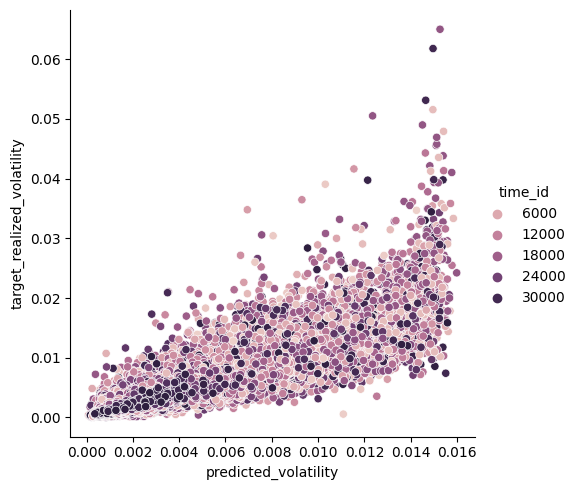

In [92]:
sns.relplot(
    data=test,
    x="predicted_volatility", y="target_realized_volatility",
    hue="time_id"
)

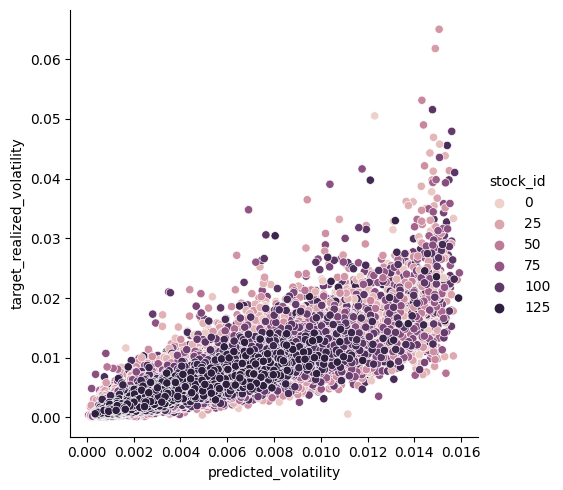

In [21]:
sns.relplot(
    data=test,
    x="predicted_volatility", y="target_realized_volatility",
    hue="stock_id"
)

In [93]:
def rmspe_test(test):
    return rmspe(test['target_realized_volatility'], test['predicted_volatility'])
    
test_time = test.groupby('time_id').apply(rmspe_test).to_frame(name='RMSPE').reset_index()
test_stock = test.groupby('stock_id').apply(rmspe_test).to_frame(name='RMSPE').reset_index()

In [94]:
test_time.describe().transpose()[1:]

,count,mean,std,min,25%,50%,75%,max
RMSPE,3830.0,0.243143,0.096228,0.117058,0.20378,0.230326,0.262283,3.655258


In [95]:
test_stock.describe().transpose()[1:]

,count,mean,std,min,25%,50%,75%,max
RMSPE,112.0,0.247367,0.08517,0.157731,0.201101,0.230167,0.265822,0.87686


In [96]:
test_all = test.apply(rmspe_test, axis=1)

<AxesSubplot:>

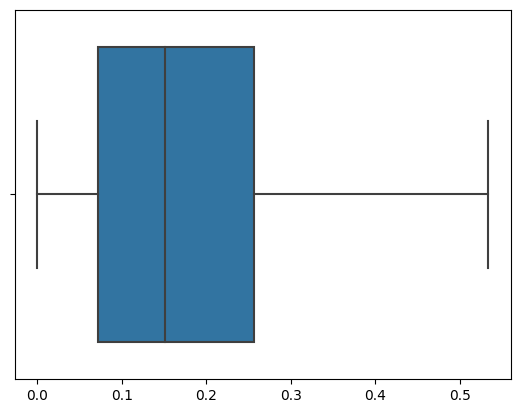

In [97]:
sns.boxplot(x=test_all, showfliers=False)

### By Time ID

<AxesSubplot:xlabel='RMSPE'>

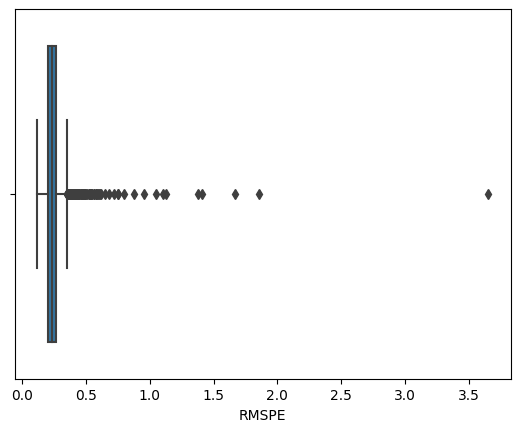

In [98]:
sns.boxplot(x=test_time["RMSPE"])

<AxesSubplot:xlabel='RMSPE'>

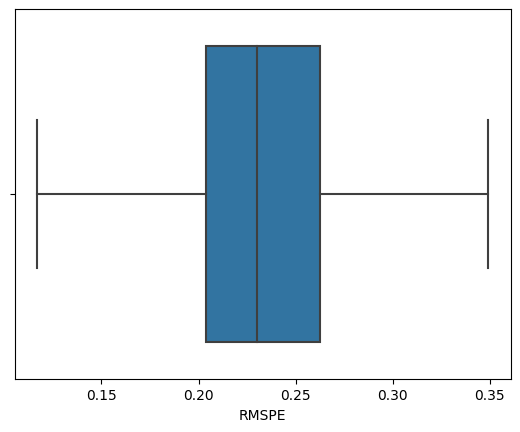

In [99]:
sns.boxplot(x=test_time["RMSPE"], showfliers=False)

In [29]:
test_time.iloc[test_time['RMSPE'].idxmax()]

time_id    29228.000000
RMSPE          3.790331
Name: 3445, dtype: float64

<Figure size 1500x800 with 0 Axes>

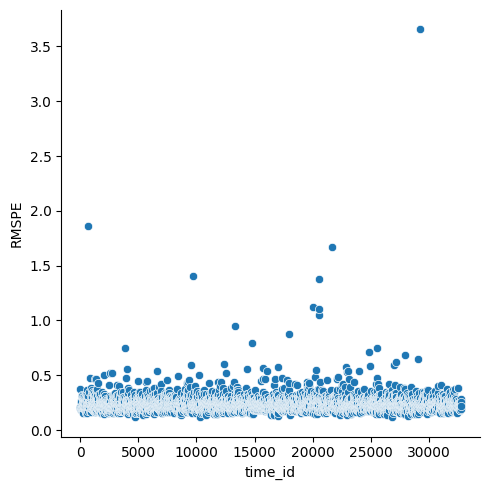

In [100]:
plt.figure(figsize=(15,8))
sns.relplot(y = 'RMSPE', x = 'time_id', data = test_time)
plt.show()

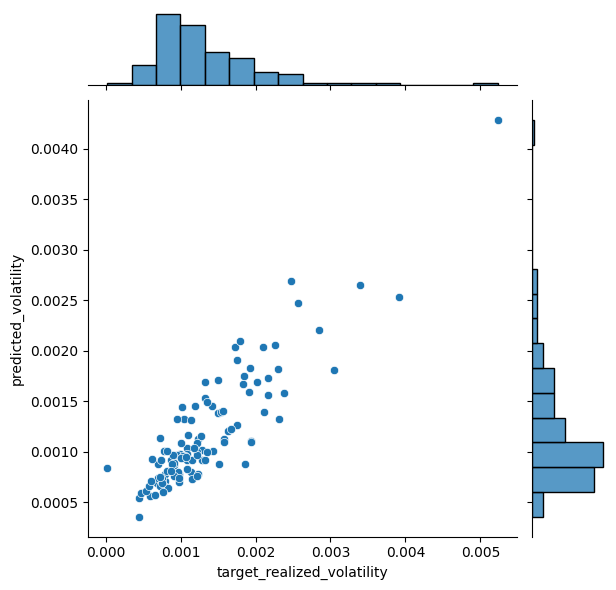

In [101]:
sub = test[test['time_id']==29228]
sns.jointplot(data=sub, x='target_realized_volatility', y='predicted_volatility')

In [102]:
test_time.iloc[test_time['RMSPE'].idxmin()]

time_id    26874.000000
RMSPE          0.117058
Name: 3201, dtype: float64

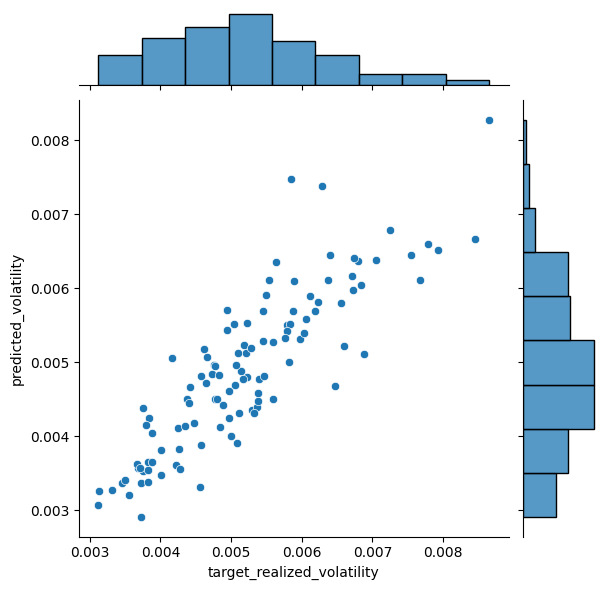

In [103]:
sub = test[test['time_id']==26874]
sns.jointplot(data=sub, x='target_realized_volatility', y='predicted_volatility')

### By Stock ID

In [104]:
test_stock.iloc[test_stock['RMSPE'].idxmax()]

stock_id    31.00000
RMSPE        0.87686
Name: 28, dtype: float64

<Figure size 1500x800 with 0 Axes>

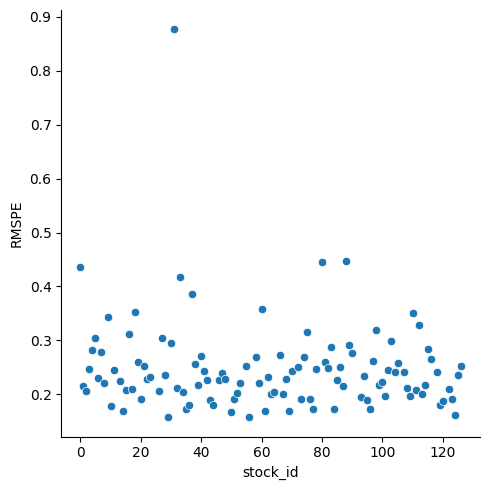

In [105]:
plt.figure(figsize=(15,8))
sns.relplot(y = 'RMSPE', x = 'stock_id',
            data = test_stock)
plt.show()

<AxesSubplot:xlabel='RMSPE'>

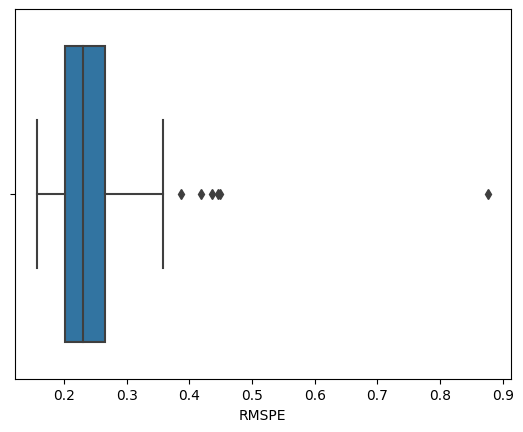

In [106]:
sns.boxplot(x=test_stock["RMSPE"])

<AxesSubplot:xlabel='RMSPE'>

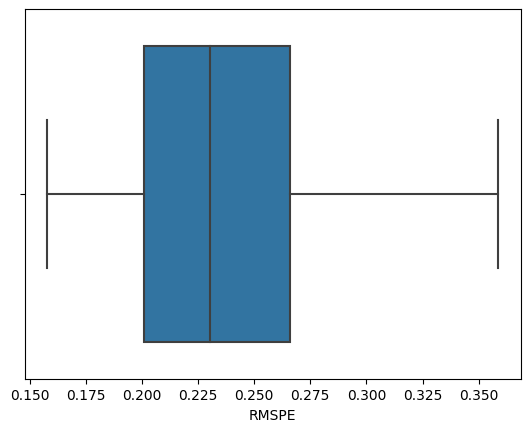

In [107]:
sns.boxplot(x=test_stock["RMSPE"], showfliers=False)

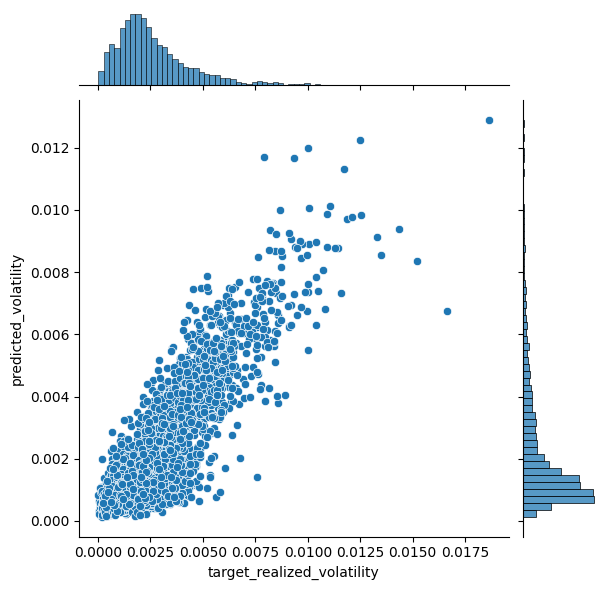

In [108]:
sub = test[test['stock_id']==31]
sns.jointplot(data=sub, x='target_realized_volatility', y='predicted_volatility')

In [109]:
test_stock.iloc[test_stock['RMSPE'].idxmin()]

stock_id    29.000000
RMSPE        0.157731
Name: 26, dtype: float64

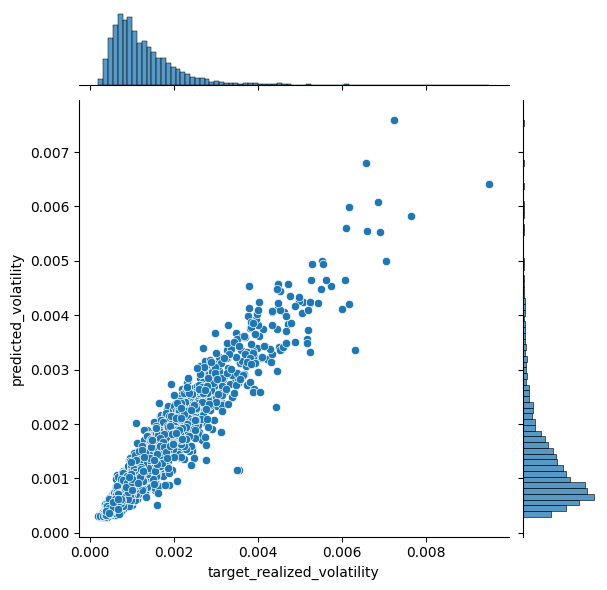

In [110]:
sub = test[test['stock_id']==29]
sns.jointplot(data=sub, x='target_realized_volatility', y='predicted_volatility')

In [111]:
test_stock[test_stock['stock_id']==31]

,stock_id,RMSPE
28,31,0.87686


## Model Feature Importance

In [145]:
import seaborn as sns

def plot_importance(importance, title='', save_to_file=None, top=None):    
    importance = importance.sort_values(
        ['Importance'], ascending=False
    )[:top]#.sort_values(['Importance'])
    
    plt.figure(figsize=(10, 8))
    #importance.plot.barh(ax=ax)
    sns.barplot(x="Importance", y="Features", data=importance.sort_values(by="Importance",ascending=False))
    
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_to_file:
        plt.savefig(save_to_file)
    plt.show()
    plt.close()

def compute_mean_importance(importance):
    res = importance[0].copy()
    res['Importance'] = np.mean(np.array(
        [df['importance'].values for df in importance]
    ), axis=0)
    
    res = res.drop(['importance'], axis=1)
    
    # reformat for plot
    return pd.DataFrame(
        {'Features':[f for f in res.index], 
         'Importance': res['Importance']}
    ).reset_index(drop=True)


### Plotting Importance by Gain & Split

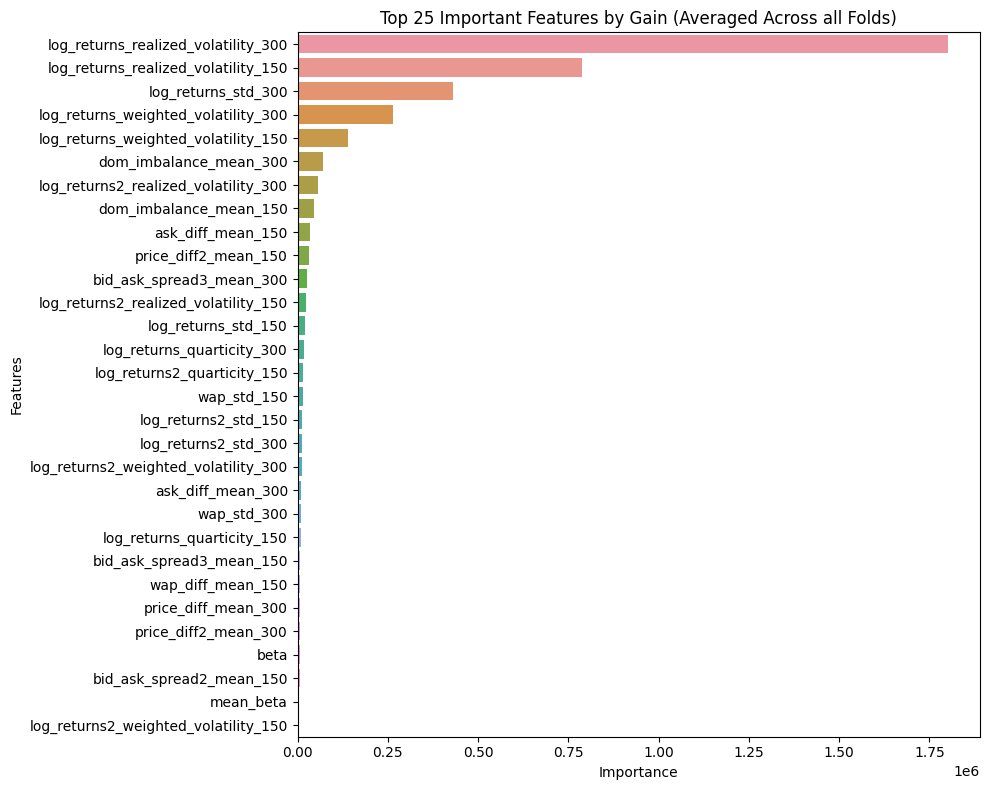

,Features,Importance
0,bds_kmeans4,5.268886e+00
1,bds_dbscan_ward5,1.627452e+01
2,dom_diff_std_150,7.356283e+01
3,bid_ask_volume_diff_std_150,1.001411e+02
4,mad_ldom,1.361530e+02
...,...,...
98,log_returns_weighted_volatility_150,1.391455e+05
99,log_returns_weighted_volatility_300,2.638399e+05
100,log_returns_std_300,4.306966e+05
101,log_returns_realized_volatility_150,7.865988e+05


In [149]:
mean_gain = compute_mean_importance(gain_importance)

plot_importance(mean_gain, title='Top 25 Important Features by Gain (Averaged Across all Folds)', top=30)

mean_gain

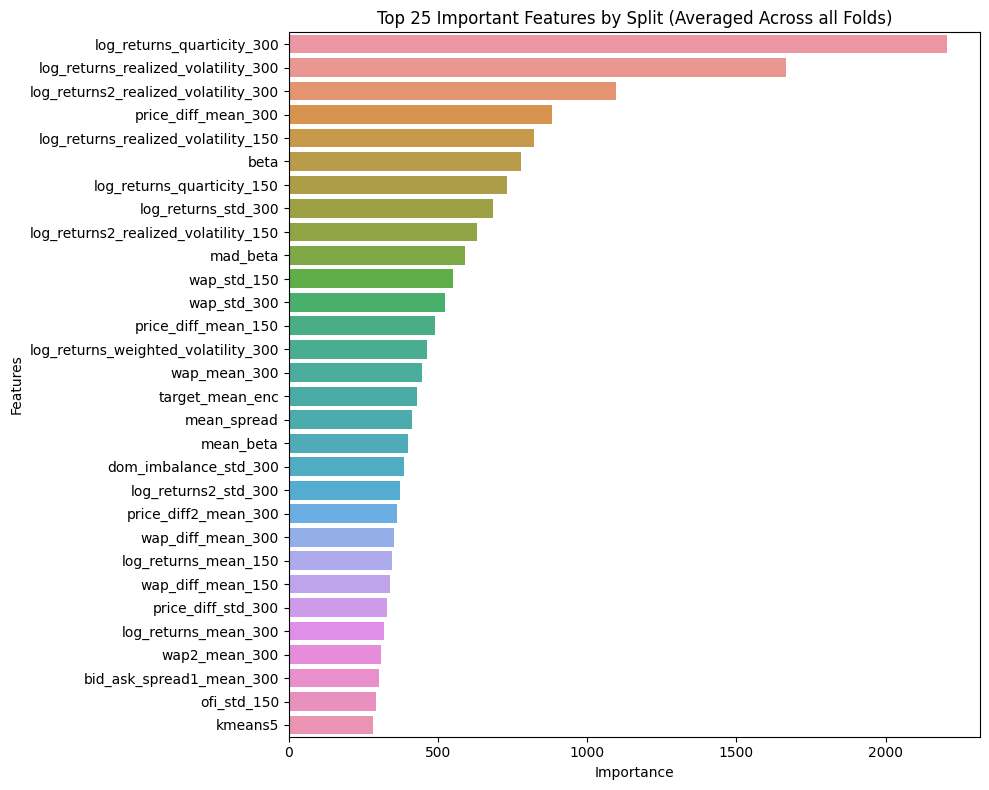

,Features,Importance
0,bds_kmeans4,1.44
1,bds_dbscan_ward5,3.52
2,dom_diff_std_150,17.80
3,mad_ldom,22.00
4,bid_ask_volume_diff_std_150,25.24
...,...,...
98,log_returns_realized_volatility_150,823.08
99,price_diff_mean_300,882.92
100,log_returns2_realized_volatility_300,1096.52
101,log_returns_realized_volatility_300,1667.68


In [148]:
mean_split = compute_mean_importance(split_importance)
plot_importance(mean_split, title='Top 25 Important Features by Split (Averaged Across all Folds)', top=30)

mean_split

### Reference Paper: LightGBM Based Optiver Realized Volatility Prediction
#### Link:  https://ieeexplore-ieee-org.ezproxy.library.sydney.edu.au/document/9543438

### Notes to Self:

 Parameters:importance_type (string, optional (default="split")) – 
 
* If “split”, result contains numbers of times the feature is used in a model. 
 
* If “gain”, result contains total gains of splits which use the feature.
 
 Returns:   result – Array with feature importances.
 Return type:   numpy array`